# Прогнозирование уровня средней заработной платы в России

In [2]:
import datetime
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from itertools import product
from scipy import stats
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', 
                     parse_dates=['month'], index_col='month', dayfirst=True)

In [4]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [5]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
WAG_C_M    284 non-null float64
dtypes: float64(1)
memory usage: 4.4 KB


In [6]:
salary.describe()

,WAG_C_M
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


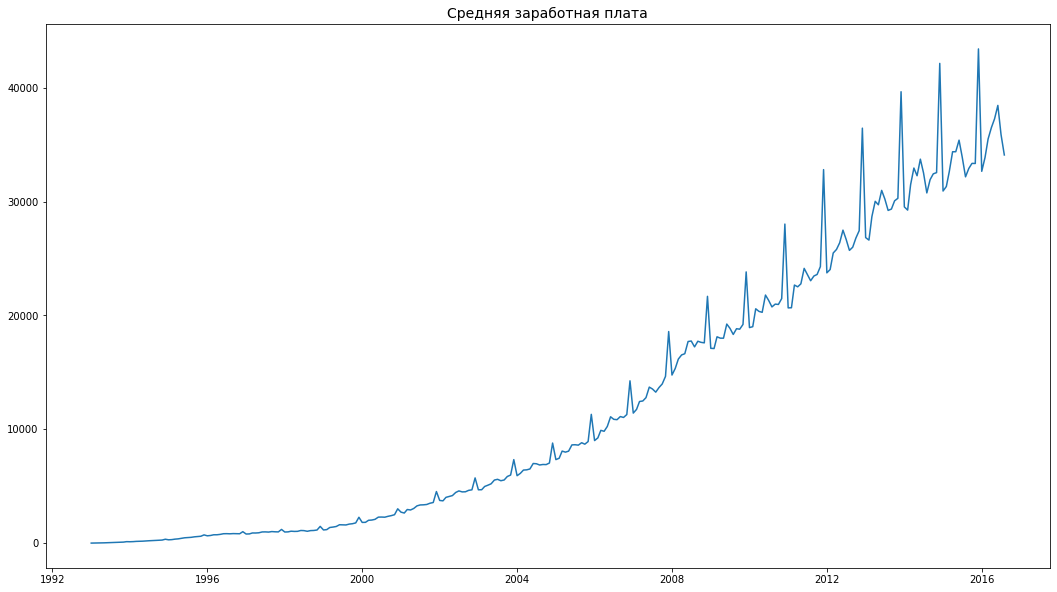

In [10]:
plt.figure(figsize=(18, 10))
plt.plot(salary['WAG_C_M'])
plt.title('Средняя заработная плата', fontsize=14)
plt.show()

На графике мы видем тренд, возрастающую во времени дисперсию и сезонность

Критерий Дики-Фуллера: p=0.9918495954854737


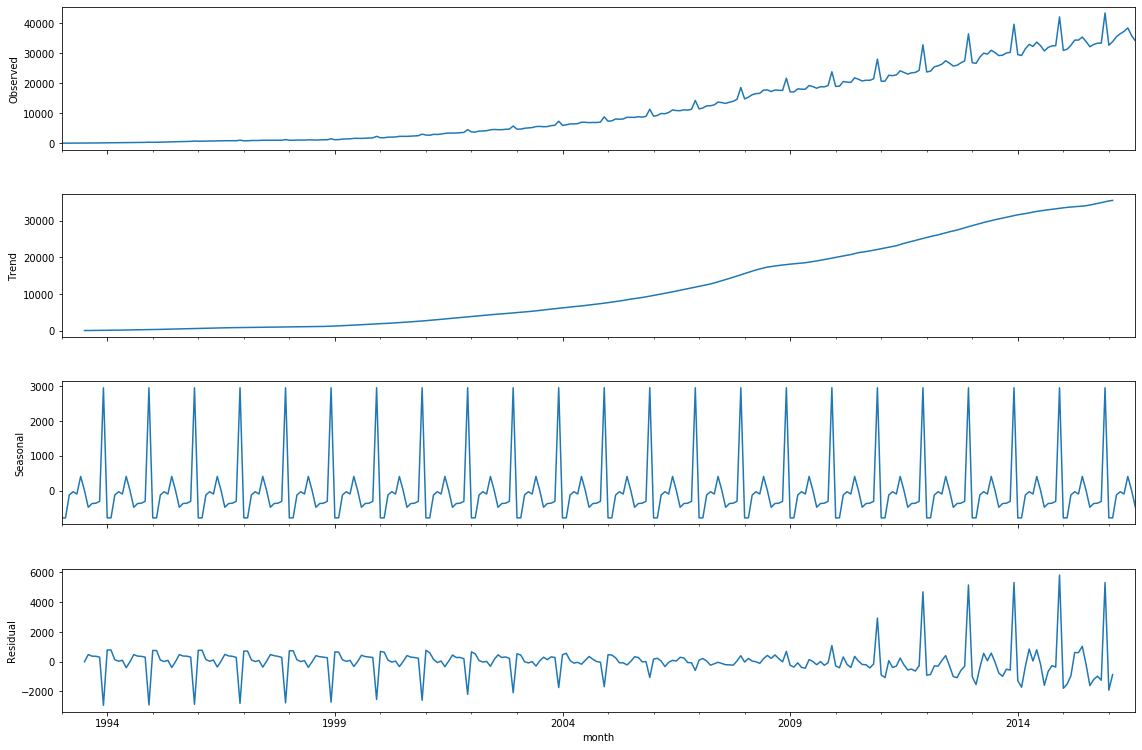

In [11]:
fig = sm.tsa.seasonal_decompose(salary).plot()
fig.set_size_inches(18, 12)
df = sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Ряд нестационарен. Видно наличие тренда и сезонности. Сделаем преобразование Бокса-Кокса

In [13]:
def invboxcox(y, lmbda):
    """Обратное преобразование Бокса-Кокса
    arguments:
        y : time series
        lmbda: lambda parameter of Box-Cox transform
    returns:
        inverted time series
    """
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584
Критерий Дики-Фуллера: p=0.6968987634832586


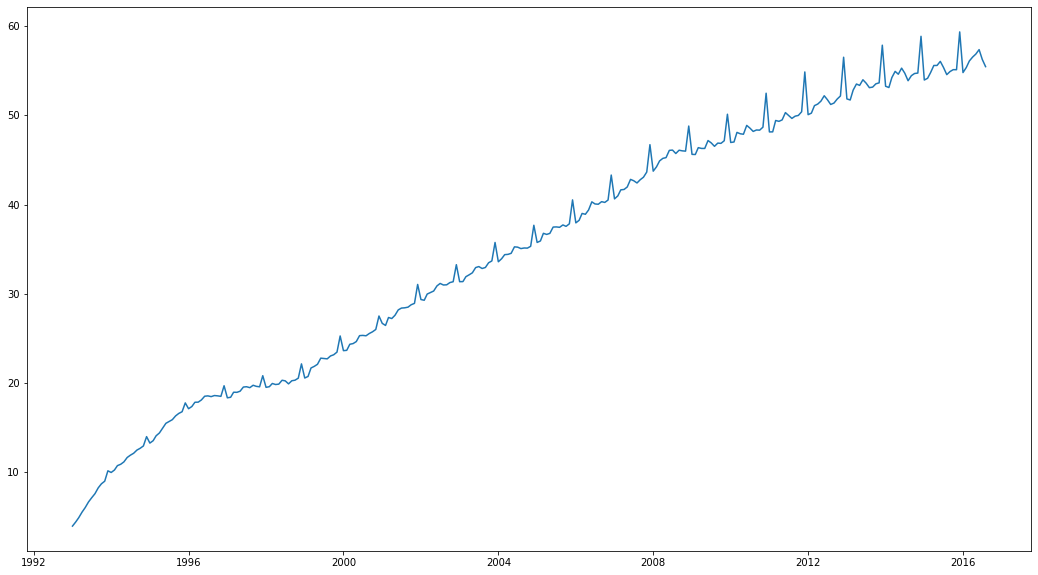

In [14]:
salary['WAG_C_M_boxcox'], lmbda = stats.boxcox(salary['WAG_C_M'])
plt.figure(figsize=(18, 10))
plt.plot(salary['WAG_C_M_boxcox'])
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda}")
df = sm.tsa.stattools.adfuller(salary['WAG_C_M_boxcox'])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Ряд до сих пор нестационарен. Сделаем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697133494791808


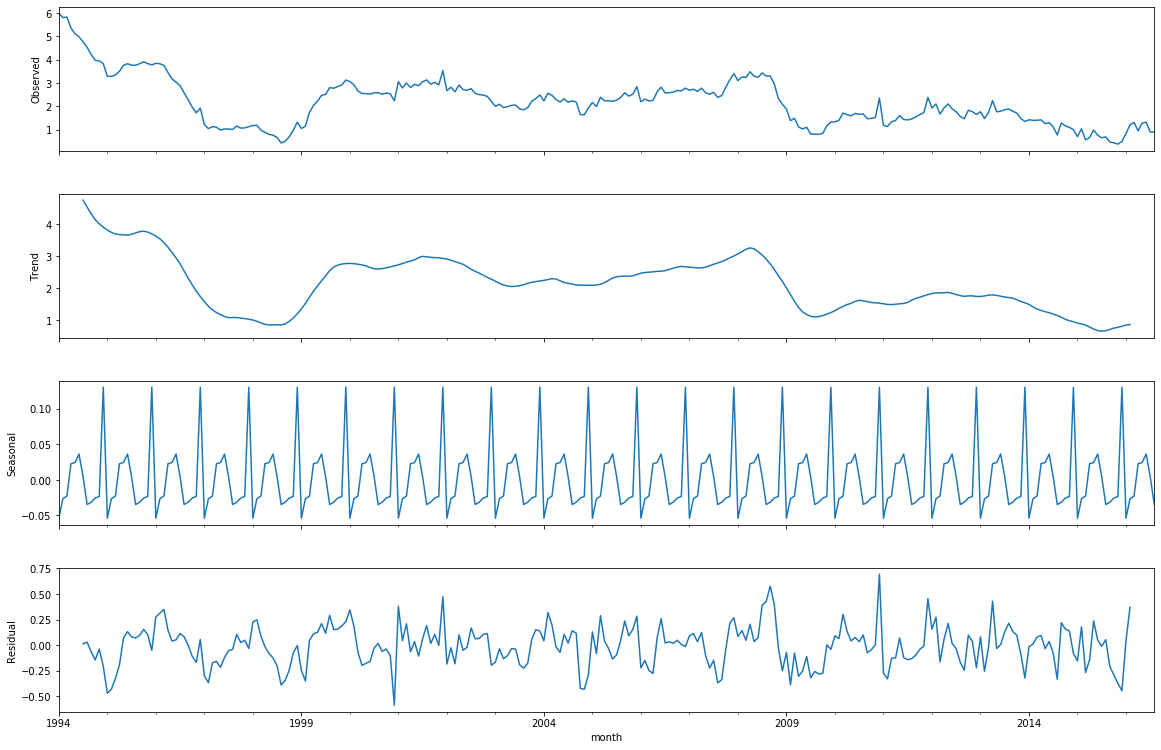

In [15]:
salary['WAG_C_M_boxcox_diff'] = (
    salary['WAG_C_M_boxcox'] - salary['WAG_C_M_boxcox'].shift(12))
fig = sm.tsa.seasonal_decompose(salary['WAG_C_M_boxcox_diff'][12:]).plot()
fig.set_size_inches(18, 12)
df = sm.tsa.stattools.adfuller(salary['WAG_C_M_boxcox_diff'][12:])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Гипотеза о нестационарности отвергается, но тренд все еще присутсвует. Продифференцируем еще раз

Критерий Дики-Фуллера: p=5.203603715821735e-08


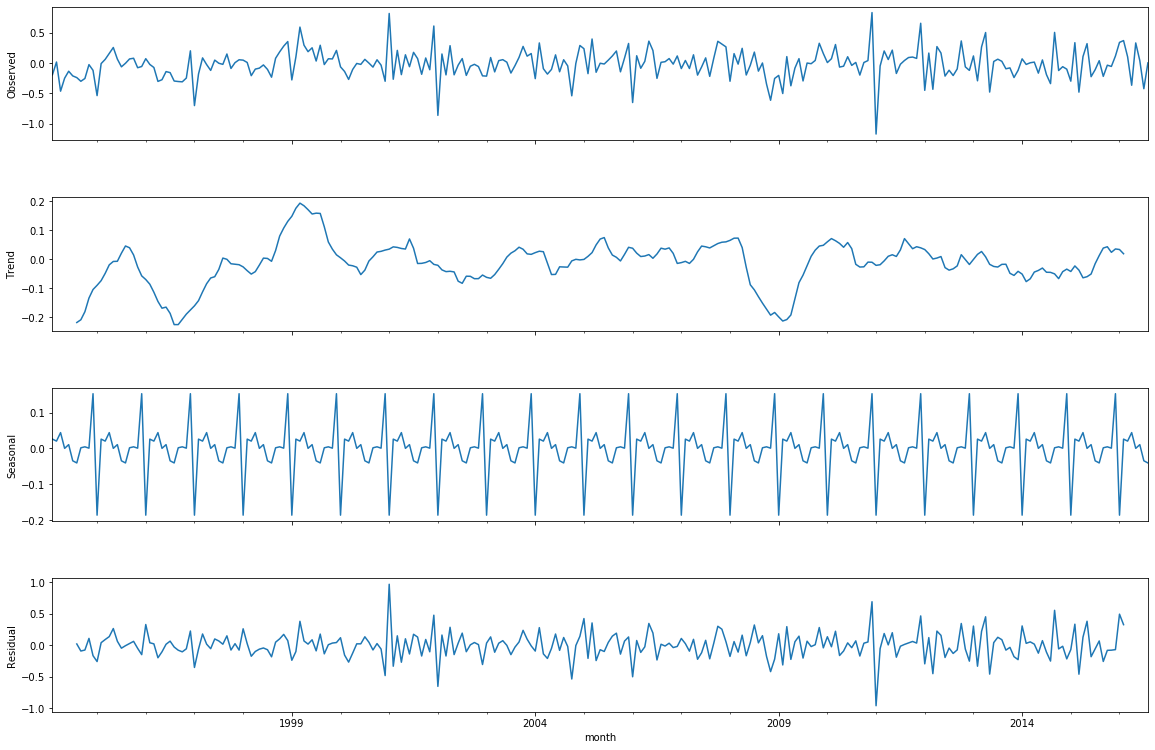

In [16]:
salary['WAG_C_M_boxcox_diff2'] = (
    salary['WAG_C_M_boxcox_diff'] - salary['WAG_C_M_boxcox_diff'].shift(1))
fig = sm.tsa.seasonal_decompose(salary['WAG_C_M_boxcox_diff2'][13:]).plot()   
fig.set_size_inches(18, 12)
df = sm.tsa.stattools.adfuller(salary['WAG_C_M_boxcox_diff2'][13:])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Гипотезу о нестационарности ряда можно уверенно отвергнуть

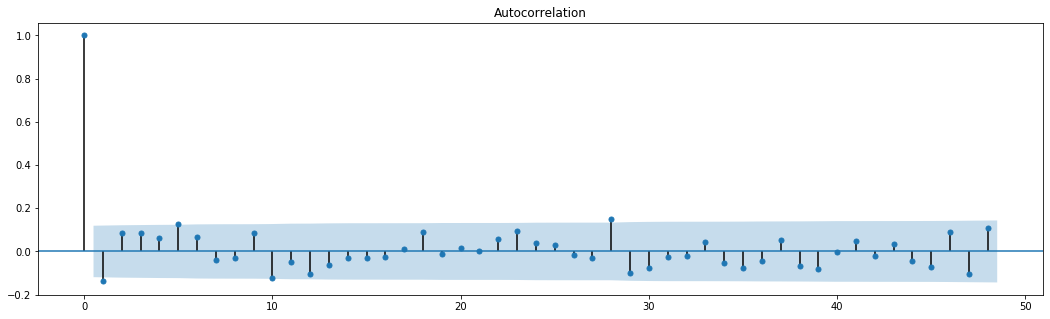

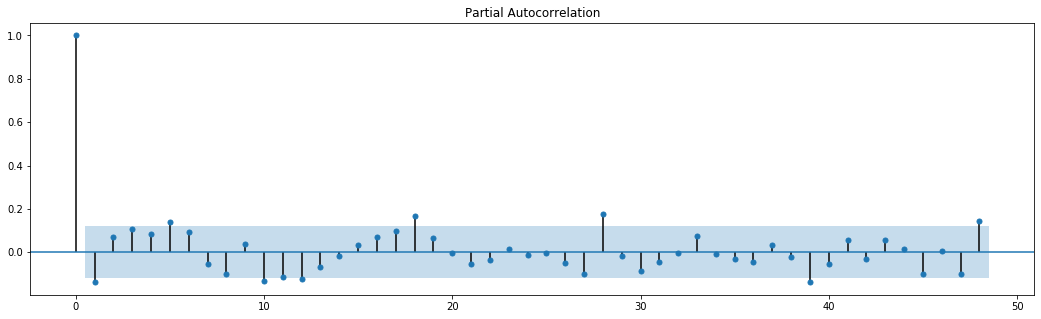

In [18]:
fig = sm.graphics.tsa.plot_acf(
    salary['WAG_C_M_boxcox_diff2'][13:].values.squeeze(), lags=48)
fig.set_size_inches(18, 5)
plt.show()

fig = sm.graphics.tsa.plot_pacf(
    salary['WAG_C_M_boxcox_diff2'][13:].values.squeeze(), lags=48)
fig.set_size_inches(18, 5)
plt.show()

Выбранные приближения: Q=0, q=1, P=4, p=5

In [20]:
ps = range(6)
d=1
qs = range(2)
Ps = range(5)
D=1
Qs = range(1)

In [21]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [22]:
results = []
best_aic = float("inf")


for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(
            salary['WAG_C_M_boxcox'], order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

100%|██████████| 60/60 [02:25<00:00,  2.42s/it]


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters       aic
56  (5, 1, 1, 0) -5.260132
36  (3, 1, 1, 0) -4.995859
51  (5, 0, 1, 0) -4.545934
59  (5, 1, 4, 0) -4.469894
54  (5, 0, 4, 0) -4.238184


In [24]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Wed, 24 Jun 2020   AIC                             -5.260
Time:                                    18:17:12   BIC                             23.557
Sample:                                01-01-1993   HQIC                             6.310
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2018      0.436      0.463      0.644      -0.653       1.057
ar.L2          0.0994      0.105   

Критерий Стьюдента: p=0.29621988116039316
Критерий Дики-Фуллера: p=1.9780183871944517e-29


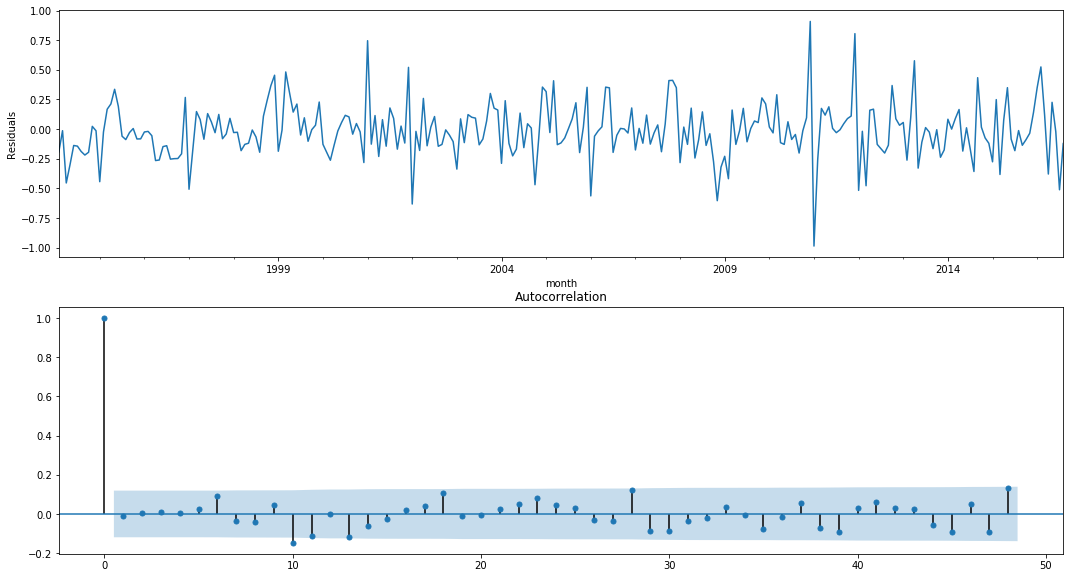

In [25]:
plt.figure(figsize=(18, 10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(
    best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

st = stats.ttest_1samp(best_model.resid[13:], 0)[1]
df = sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
print(f"Критерий Стьюдента: p={st}")
print(f"Критерий Дики-Фуллера: p={df}")

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков. Критерий Дики-Фуллера показывает, что ряд стационарен. По коррелограмме можно видеть неавтокоррелированность остатков

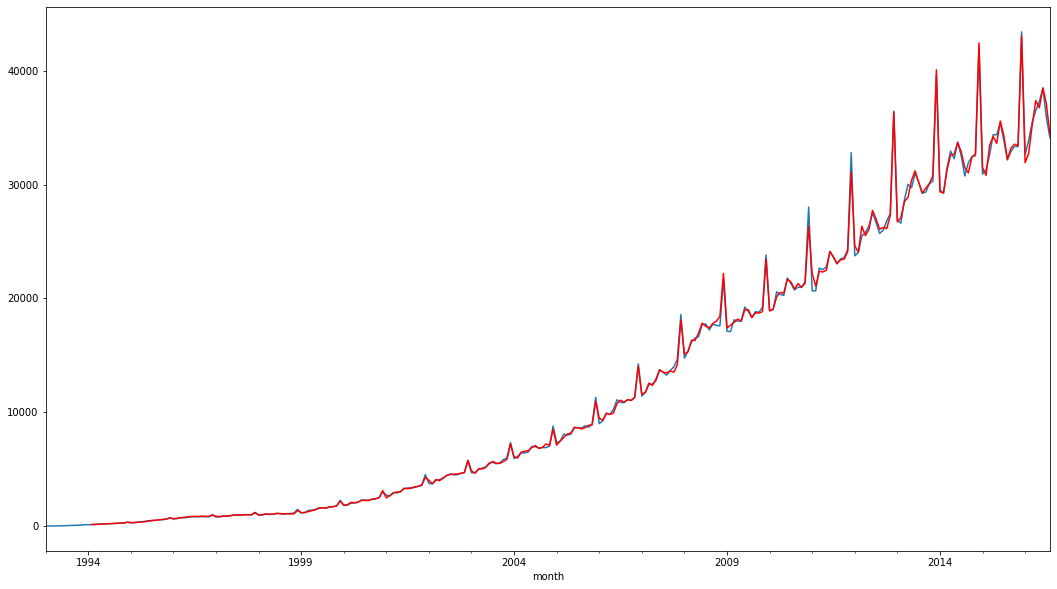

In [26]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(18, 10))
salary['WAG_C_M'].plot()
salary['model'][13:].plot(color='r')
plt.show()

Модель хорошо описывает данные, построим прогнозы

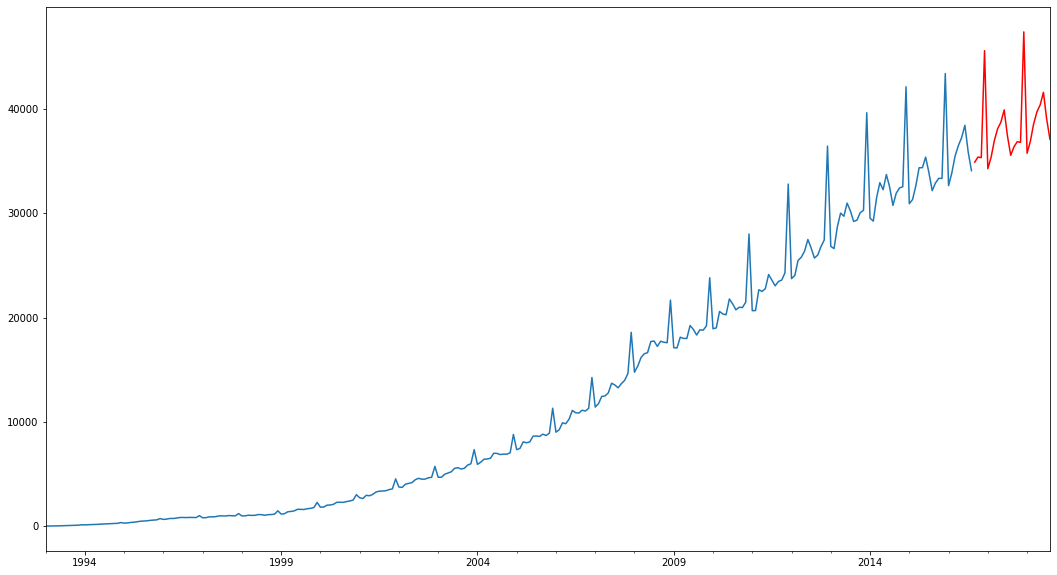

In [27]:
salary_copy = salary[['WAG_C_M']].copy()
date_list = [salary.index[-1] + relativedelta(months=x + 1) for x in range(24)]

future = pd.DataFrame(index=date_list, columns=salary_copy.columns)

salary_copy = pd.concat([salary_copy, future])
salary_copy['forecast'] = invboxcox(
    best_model.predict(start=salary.shape[0], end=salary.shape[0]+24), lmbda)

plt.figure(figsize=(18, 10))
salary_copy['WAG_C_M'].plot()
salary_copy['forecast'].plot(color='r')
plt.show()

$Вывод:$ модель адекватно строит прогнозы. Отражает тренд, сезонность и рост дисперсии